# Machine Learning Module 
The objective of the code is to be able to accuracatly predict future job vacancies in specific provinces, noc, and full time or part time. We will utilize three different machine learning modules to achieve this, linear regression, MLPRegressor, and Random Forest Regressor. 

In [533]:
# Importing main analysis libaries
import pandas as pd
import datetime as dt
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# Importing machine learning modules
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# Importing libaries for feature engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler  

# Import libaries for testing, splitting data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Importing config file for pulling from database
import config
import psycopg2

In [534]:
# Setting the seeds to be more stable states, also allowing only 30 rows of data to be displayed to save space. 
np.random.seed(0)
pd.set_option("display.max_rows", 30, "display.max_columns", None)

# IMPORT AND CLEANING

In [535]:
# Connection to database to pull CSV 
conn = psycopg2.connect(
   host = config.config["host"],
   port = config.config["port"],
   dbname =  config.config["dbname"],
   user = config.config["user"],
   password =config.config["password"])

print("Postgres Connected")
df = pd.read_sql_query('SELECT * FROM "machinelearning"', con=conn)


Postgres Connected


In [536]:
# Changing ref_date from datetime to string, dropping uneeded rows 2020-10, 2021-01, 2021-04 due to covid for ML, dropping uneeded rows GEO = Canada, NOC = total, all occupations, 
# renaming column titles and changing Value to int 

df['ref_date'] = df['ref_date'].apply(lambda x : x.strftime("%Y-%m"))
df.drop(["id", "noc_code","predicted_vacancies"],axis=1, inplace=True)
df = df[~df['ref_date'].isin(['2020-10', '2021-01', '2021-04'])]
df = df[~df['geo'].isin(['Canada'])]
df = df[~df['noc_desc'].isin(["Total, all occupations"])]
df.rename({"ref_date" : "REF_DATE", "geo" : "GEO", "noc_desc" : "NOC", "job_char" : "JOB_CHAR", "total_vacancies" : "VALUE"}, inplace=True, axis=1)
df["VALUE"] = df["VALUE"].astype(int)
df["NOC"] = df["NOC"].str.rstrip()
df

,REF_DATE,GEO,NOC,JOB_CHAR,VALUE
25,2015-04,Newfoundland and Labrador,"Business, finance and administration occupations",Full-time,430
26,2015-04,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,170
27,2015-04,Newfoundland and Labrador,Health occupations,Full-time,265
28,2015-04,Newfoundland and Labrador,Health occupations,Part-time,260
29,2015-04,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time,130
...,...,...,...,...,...
3903,2020-01,Nunavut,"Business, finance and administration occupations",Full-time,55
3904,2020-01,Nunavut,Natural and applied sciences and related occup...,Full-time,45
3905,2020-01,Nunavut,Natural and applied sciences and related occup...,Part-time,0
3906,2020-01,Nunavut,"Trades, transport and equipment operators and ...",Full-time,85


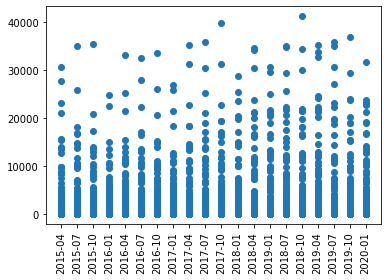

In [537]:
# Plotting the dataset just to have some sort of visual aid to assist us in understanding the data. 

plt.scatter(df.REF_DATE, df.VALUE)
plt.xticks(rotation = 90)
plt.show()

In [538]:
# Encoding Quarters by labels since orignally it is 1 4 7 10, we transform this to 1 2 3 4 Quarters, we also convert Year to INT and drop REF DATE, Formating and sorting as well
LE= LabelEncoder()
df[['YEAR', 'QUARTER']] = df['REF_DATE'].str.split('-', 1, expand=True)
df["QUARTER"]=LE.fit_transform(df["QUARTER"])
df["QUARTER"] += 1
df["YEAR"] = df["YEAR"].astype(int)
df["QUARTER"] = df["QUARTER"].astype(int)
df = df.drop(columns=["REF_DATE"])
df.sort_values(["YEAR", "QUARTER"], ascending=[True, True], inplace=True)
cols = df.columns.tolist()
cols = cols[-2:] + cols[:-2]
df = df[cols]
df

,YEAR,QUARTER,GEO,NOC,JOB_CHAR,VALUE
25,2015,2,Newfoundland and Labrador,"Business, finance and administration occupations",Full-time,430
26,2015,2,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,170
27,2015,2,Newfoundland and Labrador,Health occupations,Full-time,265
28,2015,2,Newfoundland and Labrador,Health occupations,Part-time,260
29,2015,2,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time,130
...,...,...,...,...,...,...
3903,2020,1,Nunavut,"Business, finance and administration occupations",Full-time,55
3904,2020,1,Nunavut,Natural and applied sciences and related occup...,Full-time,45
3905,2020,1,Nunavut,Natural and applied sciences and related occup...,Part-time,0
3906,2020,1,Nunavut,"Trades, transport and equipment operators and ...",Full-time,85


In [539]:
# Creating a function to grab previous job vacancy and return np.nan if it does not exist, autoregression 

def prevVacancies(row):

    # There is no previous data for 2015 Quarter 2, therefor it is automatically np.nan
    if (row["YEAR"] == 2015) & (row["QUARTER"] == 2):
        return np.nan

        # If Quarter is 1 then return the previous years Quarter 4 vacancy value IF it exists, if it does not return np.nan 
    elif (row["QUARTER"] == 1): 
        if (df.loc[(df["GEO"] == row["GEO"]) & (df["YEAR"] == (row["YEAR"]-1)) & (df["QUARTER"] == 4) & (df["NOC"] == row["NOC"]) & (df["JOB_CHAR"] == row["JOB_CHAR"])].empty):
            return np.nan
        else:
            return df.loc[(df["GEO"] == row["GEO"]) & (df["YEAR"] == (row["YEAR"]-1)) & (df["QUARTER"] == 4) & (df["NOC"] == row["NOC"]) & (df["JOB_CHAR"] == row["JOB_CHAR"])].iloc[0,5]
            
    else:
        # Returns the previous Quarters value if it is not empty, if it is empty returns np.nan
        if (df.loc[(df["GEO"] == row["GEO"]) & (df["YEAR"] == (row["YEAR"])) & (df["QUARTER"] == (row["QUARTER"]-1)) & (df["NOC"] == row["NOC"]) & (df["JOB_CHAR"] == row["JOB_CHAR"])].empty):
            return np.nan
        else:
            return df.loc[(df["GEO"] == row["GEO"]) & (df["YEAR"] == (row["YEAR"])) & (df["QUARTER"] == (row["QUARTER"]-1)) & (df["NOC"] == row["NOC"]) & (df["JOB_CHAR"] == row["JOB_CHAR"])].iloc[0,5]



In [540]:
# Creating a function to join together X_test, Y_test, and Output of machine learning model into a cohesive dataframe to allow us to observe the data easier. Recoded the encoded values. 

def Prediction_Join(Input, Y_Input, Prediction):

    Pred_df = pd.DataFrame(Prediction, columns = ["PREDICTED_VACANCIES"])

    Input.reset_index(inplace=True, drop=True)
    Y_Input.reset_index(inplace=True, drop=True)
    Input = pd.merge(Input,Y_Input,how = 'left',left_index = True, right_index = True)
    Input.rename({'VALUE' : 'CURRENT_VACANCIES'},  axis='columns', inplace=True)
    
    df_out = pd.merge(Input,Pred_df,how = 'left',left_index = True, right_index = True)
    df_out = df_out[['YEAR', 'QUARTER', 'PREVIOUS_VACANCY','CURRENT_VACANCIES', 'PREDICTED_VACANCIES', 'Alberta', 'British Columbia',
        'Manitoba', 'New Brunswick', 'Newfoundland and Labrador',
        'Northwest Territories', 'Nova Scotia', 'Nunavut', 'Ontario',
        'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon',
        'Business, finance and administration occupations',
        'Health occupations', 'Management occupations',
        'Natural and applied sciences and related occupations',
        'Natural resources, agriculture and related production occupations',
        'Occupations in art, culture, recreation and sport',
        'Occupations in education, law and social, community and government services',
        'Occupations in manufacturing and utilities',
        'Sales and service occupations',
        'Trades, transport and equipment operators and related occupations',
        'Full-time', 'Part-time']]
    df_out.sort_values(["YEAR", "QUARTER"], ascending=[True, True], inplace=True)
    df_out["PREDICTED_VACANCIES"] = df_out["PREDICTED_VACANCIES"].astype(int)

    GEO_RECODED = df_out.iloc[:,5:18].idxmax(1)
    NOC_RECODED = df_out.iloc[:,18:28].idxmax(1)
    JOB_CHAR_RECODED = df_out.iloc[:,28:30].idxmax(1)

    df_out = df_out.merge(GEO_RECODED.rename("GEO"), left_index=True, right_index=True)
    df_out = df_out.merge(NOC_RECODED.rename("NOC"), left_index=True, right_index=True)
    df_out = df_out.merge(JOB_CHAR_RECODED.rename("JOB_CHAR"), left_index=True, right_index=True)
    df_out.drop(['Alberta', 'British Columbia',
        'Manitoba', 'New Brunswick', 'Newfoundland and Labrador',
        'Northwest Territories', 'Nova Scotia', 'Nunavut', 'Ontario',
        'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon',
        'Business, finance and administration occupations',
        'Health occupations', 'Management occupations',
        'Natural and applied sciences and related occupations',
        'Natural resources, agriculture and related production occupations',
        'Occupations in art, culture, recreation and sport',
        'Occupations in education, law and social, community and government services',
        'Occupations in manufacturing and utilities',
        'Sales and service occupations',
        'Trades, transport and equipment operators and related occupations',
        'Full-time', 'Part-time'], axis=1, inplace=True)
    df_out = df_out[['YEAR', 'QUARTER', 'GEO', 'NOC', 'JOB_CHAR', 'PREVIOUS_VACANCY', 'CURRENT_VACANCIES',
        'PREDICTED_VACANCIES']]
    
    return df_out

In [541]:
# Applying function prevVacancies to dataframe for autoregression, we drop rows that do not have previous quarters i.e. 2020 Q1 data. 
df["PREVIOUS_VACANCY"] = df.apply(prevVacancies, axis=1)
df = df[df.PREVIOUS_VACANCY.notna()]
df["PREVIOUS_VACANCY"] = df["PREVIOUS_VACANCY"].astype(int)


C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [542]:
# Testing if prevVacancies is working correctly
print( df.loc[(df["GEO"] == "Alberta") & (df["YEAR"] == 2020) & (df["QUARTER"] == 1) & (df["NOC"] == "Health occupations") & (df["JOB_CHAR"] == "Full-time")].iloc[0,5] )
print( df.loc[(df["GEO"] == "Alberta") & (df["YEAR"] == 2019) & (df["QUARTER"] == 4) & (df["NOC"] == "Health occupations") & (df["JOB_CHAR"] == "Full-time")].iloc[0,5] )
df.loc[(df["GEO"] == "Alberta") & (df["YEAR"] == 2020) & (df["QUARTER"] == 1) & (df["NOC"] == "Health occupations") & (df["JOB_CHAR"] == "Full-time")]

840
690


,YEAR,QUARTER,GEO,NOC,JOB_CHAR,VALUE,PREVIOUS_VACANCY
3864,2020,1,Alberta,Health occupations,Full-time,840,690


Removing rows that do not have previous Vacancy value, only a loss of 2966 -> 2456 rows 

# ENCODING 

Here we do label encoding on columns GEO, NOC, JOB_CHAR then we do OneHotEncoding on each of the columns and merge them and remove the original column. Also reset the index since we removed rows, the index numbers will not match and when we merge we will lose data going to 2002 rows. 

Creating 3 dataframes to store the label encoding order

In [543]:
a = df["GEO"].unique()
b = [ 4,  9,  6,  3, 10,  8,  2, 11,  0,  1, 12,  7,  5]

GEO_LABEL_df = pd.DataFrame(a, columns = ["GEO"])
GEO_LABEL_df.index = b
GEO_LABEL_df.sort_index(inplace=True)
GEO_LABEL_df["GEO"].values


array(['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Northwest Territories',
       'Nova Scotia', 'Nunavut', 'Ontario', 'Prince Edward Island',
       'Quebec', 'Saskatchewan', 'Yukon'], dtype=object)

In [544]:
c = df["NOC"].unique()
d = [0, 3, 1, 6, 8, 9, 7, 2, 5, 4]

NOC_LABEL_df = pd.DataFrame(c,columns = ["NOC"])
NOC_LABEL_df.index = d
NOC_LABEL_df.sort_index(inplace=True)
NOC_LABEL_df

,NOC
0,"Business, finance and administration occupations"
1,Health occupations
2,Management occupations
3,Natural and applied sciences and related occup...
4,"Natural resources, agriculture and related pro..."
5,"Occupations in art, culture, recreation and sport"
6,"Occupations in education, law and social, comm..."
7,Occupations in manufacturing and utilities
8,Sales and service occupations
9,"Trades, transport and equipment operators and ..."


In [545]:
e = df["JOB_CHAR"].unique()
f = [0, 1]

JOB_CHAR_LABEL_df = pd.DataFrame(e,columns = ["JOB_CHAR"])
JOB_CHAR_LABEL_df.index = f
JOB_CHAR_LABEL_df.sort_index(inplace=True)
JOB_CHAR_LABEL_df

,JOB_CHAR
0,Full-time
1,Part-time


In [546]:
for column in df.iloc[:,2:5]:
    
    df[column]=LE.fit_transform(df[column]) 
    print( df[column].unique())

df.reset_index(inplace = True, drop=True)

[ 4  9  6  3 10  8  2 11  0  1 12  7  5]
[0 3 1 6 8 9 7 2 5 4]
[0 1]


C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [547]:
enc = OneHotEncoder(sparse=False)
encode_df = pd.DataFrame(enc.fit_transform(df.GEO.values.reshape(-1,1)))
encode_df.columns = GEO_LABEL_df["GEO"].values
encode_df

,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [548]:
encode_df2 = pd.DataFrame(enc.fit_transform(df.NOC.values.reshape(-1,1)))
encode_df2.columns = NOC_LABEL_df["NOC"].values
encode_df2

,"Business, finance and administration occupations",Health occupations,Management occupations,Natural and applied sciences and related occupations,"Natural resources, agriculture and related production occupations","Occupations in art, culture, recreation and sport","Occupations in education, law and social, community and government services",Occupations in manufacturing and utilities,Sales and service occupations,"Trades, transport and equipment operators and related occupations"
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2452,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2453,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2454,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [549]:
encode_df3 = pd.DataFrame(enc.fit_transform(df.JOB_CHAR.values.reshape(-1,1)))
encode_df3.columns = JOB_CHAR_LABEL_df["JOB_CHAR"].values
encode_df3

,Full-time,Part-time
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,1.0,0.0
...,...,...
2451,1.0,0.0
2452,1.0,0.0
2453,1.0,0.0
2454,1.0,0.0


In [550]:
df = df.merge(encode_df,left_index=True,right_index=True).drop("GEO",1)
df = df.merge(encode_df2,left_index=True,right_index=True).drop("NOC",1)
df = df.merge(encode_df3,left_index=True,right_index=True).drop("JOB_CHAR",1)
df

C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,YEAR,QUARTER,VALUE,PREVIOUS_VACANCY,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon,"Business, finance and administration occupations",Health occupations,Management occupations,Natural and applied sciences and related occupations,"Natural resources, agriculture and related production occupations","Occupations in art, culture, recreation and sport","Occupations in education, law and social, community and government services",Occupations in manufacturing and utilities,Sales and service occupations,"Trades, transport and equipment operators and related occupations",Full-time,Part-time
0,2015,3,330,430,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2015,3,225,170,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2015,3,315,265,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2015,3,350,260,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2015,3,260,130,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,2020,1,60,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2452,2020,1,65,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2453,2020,1,55,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2454,2020,1,45,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Convert all values to int 

In [551]:
for c in (df.iloc[:,2:29].columns):
    df[c] = df[c].astype(int)


# SPLITTING DATA FOR ML MODEL


In [552]:
cols = df.columns.tolist()
cols = cols[2:] + cols[:2]
df = df[cols]
df


,VALUE,PREVIOUS_VACANCY,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon,"Business, finance and administration occupations",Health occupations,Management occupations,Natural and applied sciences and related occupations,"Natural resources, agriculture and related production occupations","Occupations in art, culture, recreation and sport","Occupations in education, law and social, community and government services",Occupations in manufacturing and utilities,Sales and service occupations,"Trades, transport and equipment operators and related occupations",Full-time,Part-time,YEAR,QUARTER
0,330,430,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2015,3
1,225,170,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2015,3
2,315,265,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2015,3
3,350,260,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2015,3
4,260,130,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,2015,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,60,35,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,2020,1
2452,65,35,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,2020,1
2453,55,45,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2020,1
2454,45,50,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2020,1


In [553]:
Y = df.iloc[:,0]
Y

0       330
1       225
2       315
3       350
4       260
       ... 
2451     60
2452     65
2453     55
2454     45
2455     85
Name: VALUE, Length: 2456, dtype: int32

In [554]:
X = df.iloc[:,1:29]
cols = X.columns.tolist()
cols = cols[-2:] + cols[:-2]
X = X[cols]
X

,YEAR,QUARTER,PREVIOUS_VACANCY,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon,"Business, finance and administration occupations",Health occupations,Management occupations,Natural and applied sciences and related occupations,"Natural resources, agriculture and related production occupations","Occupations in art, culture, recreation and sport","Occupations in education, law and social, community and government services",Occupations in manufacturing and utilities,Sales and service occupations,"Trades, transport and equipment operators and related occupations",Full-time,Part-time
0,2015,3,430,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,2015,3,170,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,2015,3,265,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,2015,3,260,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,2015,3,130,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,2020,1,35,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
2452,2020,1,35,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2453,2020,1,45,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2454,2020,1,50,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [555]:
X.shape, Y.shape

((2456, 28), (2456,))

In [556]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train.shape, Y_train.shape

((1964, 28), (1964,))

In [557]:
X_test.shape, Y_test.shape

((492, 28), (492,))

# LINEAR REGRESSION MODEL


Defines the regrssion model

In [558]:
model = linear_model.LinearRegression()

Build training model

In [559]:
model.fit(X_train, Y_train)

LinearRegression()

In [560]:
Y_pred = model.predict(X_test)
Y_pred_train = model.predict(X_train)

In [561]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred))
print('Coefficient of determination Testing (R^2): %.2f'
      % r2_score(Y_test, Y_pred))

print('Coefficient of determination Training (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Coefficients: [  11.03812876  -58.16061272    0.95788766  -13.56419701  233.88362182
  -34.99469016  -86.51016302 -102.33540414 -160.34488021  -64.48282951
 -201.3746485   495.70142011 -138.99656142  312.1494579   -74.93148617
 -164.19963969   66.06621847   20.87472239  -67.09590676   27.2647347
 -201.71198098 -148.03131247   -7.77870616  -83.79748671  175.62763949
  218.58207803   89.05484554  -89.05484554]
Intercept: -22094.254795213667
Mean squared error (MSE): 1050117.35
Coefficient of determination Testing (R^2): 0.96
Coefficient of determination Training (R^2): 0.96


In [562]:
X_test.shape, Y_pred.shape

((492, 28), (492,))

In [563]:
df_out = Prediction_Join(X_test, Y_test, Y_pred)

In [564]:
df_out

,YEAR,QUARTER,GEO,NOC,JOB_CHAR,PREVIOUS_VACANCY,CURRENT_VACANCIES,PREDICTED_VACANCIES
37,2015,3,Quebec,Health occupations,Part-time,2585,1755,2693
65,2015,3,Ontario,"Trades, transport and equipment operators and ...",Full-time,23030,18115,22836
88,2015,3,Prince Edward Island,Occupations in manufacturing and utilities,Full-time,100,200,-64
100,2015,3,New Brunswick,Occupations in manufacturing and utilities,Full-time,1255,1100,1093
130,2015,3,Saskatchewan,"Business, finance and administration occupations",Full-time,940,820,953
...,...,...,...,...,...,...,...,...
382,2020,1,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,295,265,441
421,2020,1,Newfoundland and Labrador,Health occupations,Full-time,415,370,549
431,2020,1,Alberta,"Natural resources, agriculture and related pro...",Full-time,1495,2005,1450
436,2020,1,Quebec,"Occupations in art, culture, recreation and sport",Full-time,1700,2455,2026


In [565]:
df_out[df_out.PREDICTED_VACANCIES < 0]

,YEAR,QUARTER,GEO,NOC,JOB_CHAR,PREVIOUS_VACANCY,CURRENT_VACANCIES,PREDICTED_VACANCIES
88,2015,3,Prince Edward Island,Occupations in manufacturing and utilities,Full-time,100,200,-64
345,2015,3,Saskatchewan,"Occupations in art, culture, recreation and sport",Full-time,120,45,-45
36,2015,4,Saskatchewan,Health occupations,Part-time,235,295,-3
98,2015,4,Manitoba,"Occupations in art, culture, recreation and sport",Part-time,80,30,-280
168,2015,4,Nunavut,Management occupations,Full-time,95,55,-173
184,2015,4,Nova Scotia,"Occupations in education, law and social, comm...",Part-time,255,145,-2
316,2016,3,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Part-time,65,60,-152
42,2016,4,Nunavut,Management occupations,Full-time,50,35,-205
182,2016,4,Prince Edward Island,Occupations in manufacturing and utilities,Full-time,180,125,-35
268,2016,4,Nunavut,"Business, finance and administration occupations",Full-time,35,35,-86


In [566]:
df_out.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['YEAR', 'QUARTER', 'GEO', 'NOC', 'JOB_CHAR', 'PREVIOUS_VACANCY',
       'CURRENT_VACANCIES', 'PREDICTED_VACANCIES'],
      dtype='object')>

C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='VALUE'>

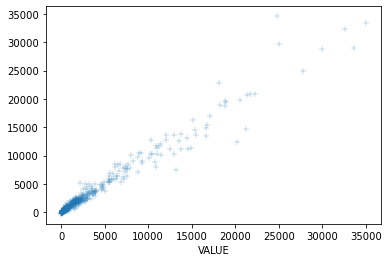

In [567]:
sns.scatterplot(Y_test, Y_pred, marker="+", alpha=0.5)

# MLP REGRESSOR MODEL


In [568]:
X_train_MLP, X_test_MLP, Y_train_MLP, Y_test_MLP = train_test_split(X, Y, test_size=0.2)
X_train_MLP.shape, Y_train_MLP.shape

MSE_Train = [0 for a in range(800)]
MSE_Test = [0 for a in range(800)]


In [569]:
X_train_MLP.shape, Y_train_MLP.shape

((1964, 28), (1964,))

In [570]:
X

,YEAR,QUARTER,PREVIOUS_VACANCY,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon,"Business, finance and administration occupations",Health occupations,Management occupations,Natural and applied sciences and related occupations,"Natural resources, agriculture and related production occupations","Occupations in art, culture, recreation and sport","Occupations in education, law and social, community and government services",Occupations in manufacturing and utilities,Sales and service occupations,"Trades, transport and equipment operators and related occupations",Full-time,Part-time
0,2015,3,430,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,2015,3,170,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,2015,3,265,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,2015,3,260,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,2015,3,130,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,2020,1,35,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
2452,2020,1,35,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2453,2020,1,45,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2454,2020,1,50,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


for i in range(800):
    model_MLP = MLPRegressor(
        hidden_layer_sizes=(15,15),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
        learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=(i+1), shuffle=True,
        random_state=1, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
        early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model_MLP.fit(X_train_MLP,Y_train_MLP)
    Y_pred_MLP = model_MLP.predict(X_test_MLP)
    Y_pred_MLP_train = model_MLP.predict(X_train_MLP) 
    MSE_Train[i-1] =  mean_squared_error(Y_train_MLP, Y_pred_MLP_train)
    MSE_Test[i-1] = mean_squared_error(Y_test_MLP, Y_pred_MLP)
        

In [571]:
scaler = StandardScaler()
scaler.fit(X)
X_train_MLP_scaled = scaler.transform(X_train_MLP)
X_test_MLP_scaled = scaler.transform(X_test_MLP)

x = pd.Series(range(0,800))

plt.plot(x,MSE_Train,x,MSE_Test)

In [572]:
model_MLP = MLPRegressor(
    hidden_layer_sizes=(28,28),  activation='relu', solver='adam', alpha=0.0001, batch_size='auto',
    learning_rate='adaptive', learning_rate_init=0.001, power_t=0.5, max_iter=5000, shuffle=True,
    random_state=1, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


In [573]:
model_MLP.fit(X_train_MLP_scaled,Y_train_MLP)

MLPRegressor(hidden_layer_sizes=(28, 28), learning_rate='adaptive',
             max_iter=5000, random_state=1)

In [574]:
Y_pred_MLP = model_MLP.predict(X_test_MLP_scaled)

In [575]:
print(model_MLP.n_layers_)
print('Accuracy training : {:.3f}'.format(model_MLP.score(X_train_MLP_scaled, Y_train_MLP)))
print('Accuracy testing : {:.3f}'.format(model_MLP.score(X_test_MLP_scaled, Y_test_MLP)))
print('Coefficient of determination Testing (R^2): %.2f'
      % r2_score(Y_test_MLP, Y_pred_MLP))
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test_MLP, Y_pred_MLP))

4
Accuracy training : 0.989
Accuracy testing : 0.985
Coefficient of determination Testing (R^2): 0.99
Mean squared error (MSE): 629826.87


In [576]:
# X_raw[(X_raw["YEAR"]=2021)&(X_raw["QUARTER"]=3)]

C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='VALUE'>

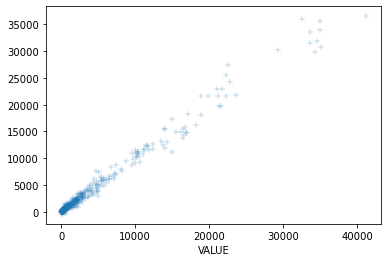

In [577]:
sns.scatterplot(Y_test_MLP, Y_pred_MLP, marker="+", alpha=0.5)

In [578]:
test = Prediction_Join(X_test_MLP, Y_test_MLP, Y_pred_MLP)

In [579]:
test

,YEAR,QUARTER,GEO,NOC,JOB_CHAR,PREVIOUS_VACANCY,CURRENT_VACANCIES,PREDICTED_VACANCIES
10,2015,3,Ontario,"Occupations in education, law and social, comm...",Part-time,3485,3250,3707
20,2015,3,British Columbia,Natural and applied sciences and related occup...,Full-time,3920,4015,3803
40,2015,3,Ontario,Management occupations,Full-time,9860,9610,10944
46,2015,3,Saskatchewan,Sales and service occupations,Part-time,3060,2775,2541
49,2015,3,Ontario,"Natural resources, agriculture and related pro...",Full-time,8560,4710,7587
...,...,...,...,...,...,...,...,...
379,2020,1,Ontario,Sales and service occupations,Part-time,36765,22605,27398
398,2020,1,Quebec,Sales and service occupations,Part-time,17105,14075,11830
400,2020,1,Manitoba,Sales and service occupations,Full-time,2495,2290,3316
404,2020,1,New Brunswick,"Trades, transport and equipment operators and ...",Full-time,1070,1000,1384


In [580]:
test[test["PREDICTED_VACANCIES"] < 0]


,YEAR,QUARTER,GEO,NOC,JOB_CHAR,PREVIOUS_VACANCY,CURRENT_VACANCIES,PREDICTED_VACANCIES
34,2016,1,Newfoundland and Labrador,Health occupations,Full-time,345,300,-211
95,2016,2,New Brunswick,"Occupations in art, culture, recreation and sport",Full-time,70,210,-6
133,2016,2,Newfoundland and Labrador,"Business, finance and administration occupations",Part-time,40,75,-158
426,2016,3,Nunavut,Sales and service occupations,Full-time,55,70,-134
380,2016,4,Nunavut,Management occupations,Full-time,50,35,-50
223,2017,2,Saskatchewan,"Occupations in art, culture, recreation and sport",Full-time,110,100,-158
343,2017,2,Yukon,Management occupations,Full-time,25,35,-4
236,2018,1,Newfoundland and Labrador,"Business, finance and administration occupations",Part-time,45,75,-118
268,2018,2,Nova Scotia,"Trades, transport and equipment operators and ...",Part-time,250,230,-31
476,2018,3,Nunavut,"Business, finance and administration occupations",Part-time,25,30,-42


In [581]:
test.to_csv(r'Resources/MLP_Test_Output.csv', index = False)

# RANDOM FOREST REGRESSOR 

In [582]:
# Saving feature names for later use
feature_list = list(X.columns)

In [583]:
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size = 0.25, random_state = 42)

In [584]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1842, 28)
Training Labels Shape: (1842,)
Testing Features Shape: (614, 28)
Testing Labels Shape: (614,)


In [585]:
# The baseline predictions are the historical averages
baseline_preds = test_features.iloc[:, feature_list.index('PREVIOUS_VACANCY')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))


Average baseline error:  526.92


In [586]:
# Instantiate model with 1000 decision trees
model_RF = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
model_RF.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [587]:
# Use the forest's predict method on the test data
predictions = model_RF.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))
print(model_RF.score)
print('Accuracy testing : {:.3f}'.format(model_RF.score(test_features, test_labels)))
print('Coefficient of determination Testing (R^2): %.2f'
      % r2_score(test_labels, predictions))
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(test_labels, predictions))

Mean Absolute Error: 459.67
<bound method RegressorMixin.score of RandomForestRegressor(n_estimators=1000, random_state=42)>
Accuracy testing : 0.978
Coefficient of determination Testing (R^2): 0.98
Mean squared error (MSE): 832487.16


C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='VALUE'>

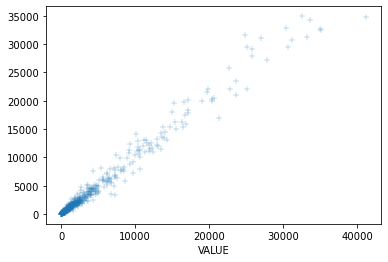

In [588]:
sns.scatterplot(test_labels, predictions, marker="+", alpha=0.5)